This notebooks shows a way to estimate the threshold of strong-headtail or mode-coupling instabilities for a single-bunch using the standard Gaussian theory. 

# Import packages

In [1]:
# %matplotlib qt5
%matplotlib inline

from functools import partial

import numpy as np
import matplotlib.pyplot as mplt

from pycolleff.longitudinal_equilibrium import ImpedanceSource, \
    LongitudinalEquilibrium
import pycolleff.rings.sirius as sirius
import pycolleff.impedances as imp
import pycolleff.materials_params as mat_par

# Create a resistive wall impedance to be used as example

In [2]:
cu_cond = mat_par.cu_cond
cu_rel_time = mat_par.cu_rel_time
neg_cond = mat_par.neg_cond
neg_rel_time = mat_par.neg_rel_time
neg_thick = mat_par.neg_thick
ndfe_cond = mat_par.ndfe_cond
ndfe_mur = mat_par.ndfe_mur

energy = 3e9  # [eV]
length = 500  # [m]

epb = np.array([1, 1, 1, 1, 1])
mub = np.array([1, 1, 1, 1, ndfe_mur])
ange = np.array([0, 0, 0, 0, 0])
angm = np.array([0, 0, 0, 0, 0])
sigmadc = np.array([0, neg_cond, cu_cond, 0, ndfe_cond])
tau = np.array([0, neg_rel_time, cu_rel_time, 0, 0])

radius = 12e-3 + np.array([-neg_thick, 0, 1e-3, 3e-3])

ang_freq = imp.get_default_reswall_w(radius=radius[0], energy=energy)

# Define maximum frequency relevant for equilibrium and instability calculations
bunlen = 2.5e-3 / 299792458 # [s]
ang_freq_cutoff = 2 * np.pi / bunlen * 3
idx = ang_freq < ang_freq_cutoff
ang_freq = ang_freq[idx]

epr, mur = imp.prepare_inputs_epr_mur(
    ang_freq, epb, mub, ange, angm, sigmadc, tau
)

Zll, Zdx, Zdy = imp.multilayer_round_chamber(
    ang_freq,
    length,
    energy,
    epr,
    mur,
    radius,
    precision=70,
    wmax_arb_prec=1e12,
    arb_prec_incl_long=False,
    print_progress=True,
)

Zll, ang_freq = imp.get_impedance_for_negative_w(
    Zll, ang_freq, impedance_type='ll'
)
Zdx = imp.get_impedance_for_negative_w(Zdx, impedance_type='t')
Zdy = imp.get_impedance_for_negative_w(Zdy, impedance_type='t')

generic = ImpedanceSource()
generic.zl_table = Zll
generic.ang_freq_table = ang_freq

# Methods: Impedance or Wake
generic.calc_method = ImpedanceSource.Methods.ImpedanceDFT

# Device type: Active or Passive
generic.active_passive = ImpedanceSource.ActivePassive.Passive

0000/0302 -> freq =        0.1  (ET: 0.06 s)
0001/0302 -> freq =       0.11  (ET: 0.03 s)
0002/0302 -> freq =       0.12  (ET: 0.03 s)
0003/0302 -> freq =       0.13  (ET: 0.03 s)
0004/0302 -> freq =       0.15  (ET: 0.03 s)
0005/0302 -> freq =       0.16  (ET: 0.03 s)
0006/0302 -> freq =       0.17  (ET: 0.03 s)
0007/0302 -> freq =       0.19  (ET: 0.03 s)
0008/0302 -> freq =       0.21  (ET: 0.03 s)
0009/0302 -> freq =       0.23  (ET: 0.03 s)
0010/0302 -> freq =       0.25  (ET: 0.03 s)
0011/0302 -> freq =       0.28  (ET: 0.03 s)
0012/0302 -> freq =       0.31  (ET: 0.03 s)
0013/0302 -> freq =       0.34  (ET: 0.03 s)
0014/0302 -> freq =       0.37  (ET: 0.03 s)
0015/0302 -> freq =        0.4  (ET: 0.03 s)
0016/0302 -> freq =       0.44  (ET: 0.03 s)
0017/0302 -> freq =       0.49  (ET: 0.03 s)
0018/0302 -> freq =       0.53  (ET: 0.03 s)
0019/0302 -> freq =       0.59  (ET: 0.03 s)
0020/0302 -> freq =       0.64  (ET: 0.03 s)
0021/0302 -> freq =       0.71  (ET: 0.03 s)
0022/0302 

In [4]:
print(f'{ang_freq_cutoff / 2 / np.pi * 1e-9:.1f} GHz')

359.8 GHz


# Define methods

In [10]:
def calculate_longeq_single_bunch_vs_current(
    ring, impedance_sources, currents
):
    """Calculate longitudinal equilibrium."""
    print('Calculating Longitudinal Equilibrium...')
    fillp = np.zeros(ring.harm_num, dtype=float)
    fillp[0] = 1
    longeq = LongitudinalEquilibrium(
        ring=ring,
        impedance_sources=impedance_sources,
        fillpattern=fillp,
    )
    longeq.feedback_on = False
    longeq.zgrid = np.linspace(-1, 1, 2001) * ring.rf_lamb / 2
    longeq.max_mode = 1000*ring.harm_num
    longeq.min_mode0_ratio = 1e-10  # criteria for convergence

    bunlen, syncfreq = [], []
    for i, cur in enumerate(currents):
        longeq.ring.total_current = cur
        print(f'{i+1:03d}/{len(currents):03d} --> {cur*1e3:.3f}mA')
        _ = longeq.calc_longitudinal_equilibrium(
            niter=1000, tol=1e-8, beta=0.1, m=3, print_flag=False
        )
        res = longeq.calc_synchrotron_frequency(
            method="action", max_amp=5, nrpts=100
        )
        syncfreq.append(res['avg_sync_freq'])
        dist, _ = longeq.calc_distributions_from_voltage()
        _, sigmaz = longeq.calc_moments(longeq.zgrid, dist[0])
        bunlen.append(sigmaz[0])
    return bunlen, syncfreq


def calc_mode_coupling(
    ring,
    ang_freq,
    impedance,
    currents,
    plane='x',
    max_azi=4,
    max_rad=4,
    cbmode=0,
    use_fokker=True,
    bunlen_vs_current=None,
    syncfr_vs_current=None,
):
    """."""
    bunlen0 = ring.bunlen
    synctu0 = ring.sync_tune
    curr0 = ring.total_current

    dtunes = []
    mod_mat = fok_mat = None
    for i, cur in enumerate(currents):
        ring.total_current = cur
        if bunlen_vs_current is not None:
            ring.bunlen = np.interp(
                cur, bunlen_vs_current[0], bunlen_vs_current[1]
            )
            mod_mat = None
            fok_mat = None
        if syncfr_vs_current is not None:
            ring.sync_tune = np.interp(
                cur, syncfr_vs_current[0], syncfr_vs_current[1]
            ) / ring.rev_freq
            mod_mat = None
            fok_mat = None
        dtune, mod_mat, fok_mat = ring.transverse_mode_coupling(
            w=ang_freq,
            Zt=impedance,
            plane=plane,
            max_azi=max_azi,
            max_rad=max_rad,
            cbmode=cbmode,
            use_fokker=use_fokker,
            modecoup_matrix=mod_mat,
            fokker_matrix=fok_mat,
        )
        dtune *= ring.sync_tune
        dtunes.append(dtune)
        print(
            f'{i+1:02d}/{len(currents):02d}: ' +
            f'Ib = {cur*1e3:7.3f} mA,   Grow Rate = ' +
            f'{dtune.imag.max()*ring.rev_ang_freq:7.0f} 1/s'
        )

    ring.bunlen = bunlen0
    ring.total_current = curr0

    dtunes = np.array(dtunes)
    gr = dtunes.imag * ring.rev_ang_freq
    gr = np.sort(gr)
    tushif = np.sort(dtunes.real, axis=1)

    return gr, tushif


# Define the ring model

In [12]:
ring = sirius.create_ring()
ring.en_lost_rad = 870e3
ring.gap_voltage = 3.0e6
ring.total_current = 350e-3
ring.chromx = 2.5 * 0
ring.chromy = 2.5 * 0
ring.num_bun = 1
print(ring)

Lattice Version             :   SI.v25.01-s05.02  
Circumference [m]           :       518.387       
Revolution Period [us]      :        1.729        
Revolution Frequency [kHz]  :       578.318       
Energy [GeV]                :        3.000        
U0 [keV]                    :       870.000       
Vgap [MV]                   :        3.000        
Momentum Compaction         :       1.63e-04      
Harmonic Number             :         864         
Current [mA]                :       350.000       
Current per Bunch [mA]      :       350.000       
Synchrotron Tune            :       0.00356       
Tunes x/y                   :    49.078/14.137    
Chromaticities x/y          :     0.000/0.000     
Damping Times x/y/e [ms]    :   16.9/ 22.0 /12.9  
Energy Spread [%]           :        0.0887       
Bunch Length [mm]           :        3.250        



# Calculate longitudinal equlibrium

This step is important to model de dependency of bunch length and synchrotron frequency as functions of current.

In [7]:
currents = np.linspace(0, 20, 30) * 1e-3
bunlen, syncfreq = calculate_longeq_single_bunch_vs_current(
    ring, [generic, ], currents
)

Calculating Longitudinal Equilibrium...
001/030 --> 0.000mA
002/030 --> 0.690mA
003/030 --> 1.379mA
004/030 --> 2.069mA
005/030 --> 2.759mA
006/030 --> 3.448mA
007/030 --> 4.138mA
008/030 --> 4.828mA
009/030 --> 5.517mA
010/030 --> 6.207mA
011/030 --> 6.897mA
012/030 --> 7.586mA
013/030 --> 8.276mA
014/030 --> 8.966mA
015/030 --> 9.655mA
016/030 --> 10.345mA
017/030 --> 11.034mA
018/030 --> 11.724mA


/home/facs/repos/collective_effects/pycolleff/pycolleff/longitudinal_equilibrium.py:878: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  period, _ = _quad(iintg, zli, zri)


019/030 --> 12.414mA
020/030 --> 13.103mA
021/030 --> 13.793mA
022/030 --> 14.483mA
023/030 --> 15.172mA
024/030 --> 15.862mA
025/030 --> 16.552mA
026/030 --> 17.241mA
027/030 --> 17.931mA
028/030 --> 18.621mA
029/030 --> 19.310mA
030/030 --> 20.000mA


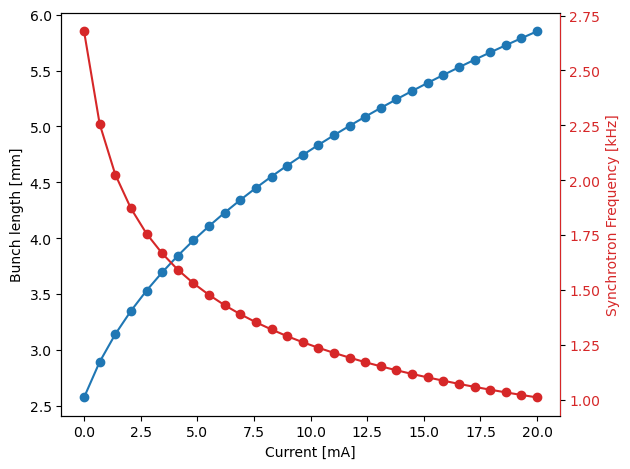

In [17]:
fig, ax = mplt.subplots(1, 1)
ay = ax.twinx()

ax.plot(currents * 1e3, np.array(bunlen) * 1e3, 'o-')
ay.plot(currents * 1e3, np.array(syncfreq) * 1e-3, 'o-', color='tab:red')

ay.spines['right'].set_color('tab:red')
mplt.setp(ay.get_yticklabels(), color='tab:red')

ay.set_ylabel('Synchrotron Frequency [kHz]', color='tab:red')
ax.set_xlabel('Current [mA]')
ax.set_ylabel('Bunch length [mm]')

fig.tight_layout()

# Calculate transverse mode-coupling

In the cell below it is possible to check the influence of the variation of the bunch length and synchrotron frequency with current on the estimative of the instability.

Any growth rate larger than zero imply instability.

In [13]:
grow, freqshit = calc_mode_coupling(
    ring,
    ang_freq=ang_freq,
    impedance=Zdx,
    currents=currents,
    plane='x',
    max_azi=4,
    max_rad=3,
    use_fokker=True,
    bunlen_vs_current=(currents, bunlen),
    # syncfr_vs_current=(currents, syncfreq),
    # bunlen_vs_current=None,
    syncfr_vs_current=None,
)

01/30: Ib =   0.000 mA,   Grow Rate =     -59 1/s
02/30: Ib =   0.690 mA,   Grow Rate =     -64 1/s
03/30: Ib =   1.379 mA,   Grow Rate =     -68 1/s
04/30: Ib =   2.069 mA,   Grow Rate =     -69 1/s
05/30: Ib =   2.759 mA,   Grow Rate =     -70 1/s
06/30: Ib =   3.448 mA,   Grow Rate =     -71 1/s
07/30: Ib =   4.138 mA,   Grow Rate =     -71 1/s
08/30: Ib =   4.828 mA,   Grow Rate =     -72 1/s
09/30: Ib =   5.517 mA,   Grow Rate =     -72 1/s
10/30: Ib =   6.207 mA,   Grow Rate =     -73 1/s
11/30: Ib =   6.897 mA,   Grow Rate =     -73 1/s
12/30: Ib =   7.586 mA,   Grow Rate =     -73 1/s
13/30: Ib =   8.276 mA,   Grow Rate =     -74 1/s
14/30: Ib =   8.966 mA,   Grow Rate =     -74 1/s
15/30: Ib =   9.655 mA,   Grow Rate =     -74 1/s
16/30: Ib =  10.345 mA,   Grow Rate =     -74 1/s
17/30: Ib =  11.034 mA,   Grow Rate =     -75 1/s
18/30: Ib =  11.724 mA,   Grow Rate =     -75 1/s
19/30: Ib =  12.414 mA,   Grow Rate =     -75 1/s
20/30: Ib =  13.103 mA,   Grow Rate =     -76 1/s


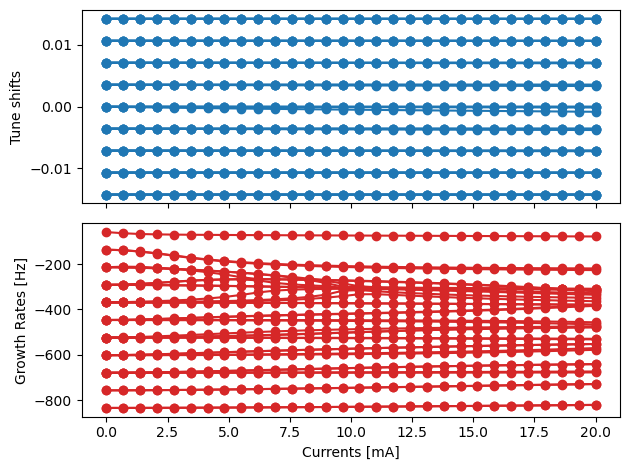

In [16]:
fig, (ax, ay) = mplt.subplots(2, 1, sharex=True)

ax.plot(currents * 1e3, freqshit, 'o-', color='tab:blue')
ay.plot(currents * 1e3, grow, 'o-', color='tab:red')
ax.set_ylabel('Tune shifts')
ay.set_ylabel('Growth Rates [Hz]')
ay.set_xlabel('Currents [mA]')
fig.tight_layout()